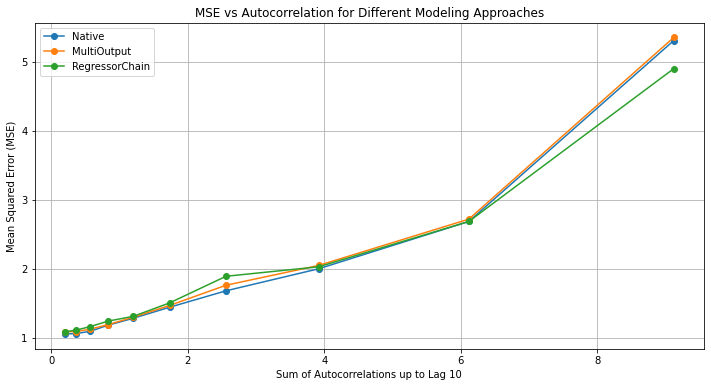

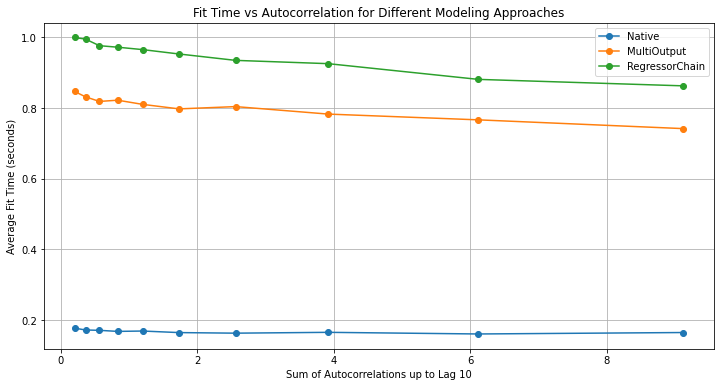

In [2]:
import numpy as np
import pandas as pd
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Function to generate datasets with varying autocorrelation
def generate_time_series(N, autocorr_coef):
    np.random.seed(0)  # For reproducibility
    y = np.zeros(N)
    e_t = np.random.normal(0, 1, N)  # White noise
    # Autoregressive coefficient
    phi = autocorr_coef
    # Generate y_t with specified autocorrelation
    for t in range(1, N):
        y[t] = phi * y[t - 1] + e_t[t]
    return pd.DataFrame({'y': y})

# Function to prepare the dataset for modeling
def prepare_dataset(data, n_lags=4, n_ahead=10):
    X, y = [], []
    for i in range(n_lags, len(data) - n_ahead):
        X.append(data['y'].values[i - n_lags:i])  # Lags of y
        y.append(data['y'].values[i:i + n_ahead])  # Next n_ahead steps
    return np.array(X), np.array(y)

# Function to compute sum of autocorrelations up to lag k
def compute_autocorrelation(y, max_lag):
    autocorr_sum = 0
    for lag in range(1, max_lag + 1):
        autocorr = np.corrcoef(y[lag:], y[:-lag])[0, 1]
        autocorr_sum += autocorr
    return autocorr_sum

# List to store results
results = []

# Range of autocorrelation coefficients to test
autocorr_coefs = np.linspace(0, 0.98, 10)  # From 0 to 0.95 in 10 steps

# Number of samples in the time series
N = 500

# Time Series Cross-Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Number of steps ahead to predict
n_ahead = 5

# Maximum lag for autocorrelation sum
max_lag = 10

for phi in autocorr_coefs:
    # Generate dataset with specified autocorrelation
    data = generate_time_series(N, phi)
    # Prepare dataset
    X, y = prepare_dataset(data, n_lags=4, n_ahead=n_ahead)
    # Compute autocorrelation sum up to max_lag
    autocorr_sum = compute_autocorrelation(data['y'].values, max_lag)
    # Initialize lists to store errors and fit times
    mse_native_list = []
    mse_multioutput_list = []
    mse_chain_list = []
    fit_time_native_list = []
    fit_time_multioutput_list = []
    fit_time_chain_list = []
    # Perform Time Series Cross-Validation
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # 1. Native Multioutput RandomForestRegressor
        start_time = time.time()
        rf_native = RandomForestRegressor(n_estimators=100, random_state=0)
        rf_native.fit(X_train, y_train)
        fit_time_native = time.time() - start_time
        y_pred_native = rf_native.predict(X_test)
        mse_native = mean_squared_error(y_test, y_pred_native)
        mse_native_list.append(mse_native)
        fit_time_native_list.append(fit_time_native)
        # 2. MultiOutputRegressor with RandomForestRegressor
        start_time = time.time()
        rf_base = RandomForestRegressor(n_estimators=100, random_state=0)
        rf_multioutput = MultiOutputRegressor(rf_base)
        rf_multioutput.fit(X_train, y_train)
        fit_time_multioutput = time.time() - start_time
        y_pred_multioutput = rf_multioutput.predict(X_test)
        mse_multioutput = mean_squared_error(y_test, y_pred_multioutput)
        mse_multioutput_list.append(mse_multioutput)
        fit_time_multioutput_list.append(fit_time_multioutput)
        # 3. RegressorChain with RandomForestRegressor
        start_time = time.time()
        rf_chain = RegressorChain(RandomForestRegressor(n_estimators=100, random_state=0))
        rf_chain.fit(X_train, y_train)
        fit_time_chain = time.time() - start_time
        y_pred_chain = rf_chain.predict(X_test)
        mse_chain = mean_squared_error(y_test, y_pred_chain)
        mse_chain_list.append(mse_chain)
        fit_time_chain_list.append(fit_time_chain)
    # Compute average MSE and fit time for all models
    avg_mse_native = np.mean(mse_native_list)
    avg_mse_multioutput = np.mean(mse_multioutput_list)
    avg_mse_chain = np.mean(mse_chain_list)
    avg_fit_time_native = np.mean(fit_time_native_list)
    avg_fit_time_multioutput = np.mean(fit_time_multioutput_list)
    avg_fit_time_chain = np.mean(fit_time_chain_list)
    # Store results
    results.append({
        'autocorr': autocorr_sum,
        'model': 'Native',
        'mse': avg_mse_native,
        'fit_time': avg_fit_time_native
    })
    results.append({
        'autocorr': autocorr_sum,
        'model': 'MultiOutput',
        'mse': avg_mse_multioutput,
        'fit_time': avg_fit_time_multioutput
    })
    results.append({
        'autocorr': autocorr_sum,
        'model': 'RegressorChain',
        'mse': avg_mse_chain,
        'fit_time': avg_fit_time_chain
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting MSE vs Autocorrelation
plt.figure(figsize=(12, 6))
for model in ['Native', 'MultiOutput', 'RegressorChain']:
    subset = results_df[results_df['model'] == model]
    plt.plot(subset['autocorr'], subset['mse'], marker='o', label=model)
plt.xlabel(f'Sum of Autocorrelations up to Lag {max_lag}')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Autocorrelation for Different Modeling Approaches')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Fit Time vs Autocorrelation
plt.figure(figsize=(12, 6))
for model in ['Native', 'MultiOutput', 'RegressorChain']:
    subset = results_df[results_df['model'] == model]
    plt.plot(subset['autocorr'], subset['fit_time'], marker='o', label=model)
plt.xlabel(f'Sum of Autocorrelations up to Lag {max_lag}')
plt.ylabel('Average Fit Time (seconds)')
plt.title('Fit Time vs Autocorrelation for Different Modeling Approaches')
plt.legend()
plt.grid(True)
plt.show()
